# STOE STADI P *operando* `.xy` background subtraction

March 2023
 
Martin Aaskov Karlsen  
Postdoc  
Ravnsbæk Group  
Department of Chemistry  
Aarhus University  
Denmark  

This code below has been developed to process and plot in-house *operando* 
powder x-ray diffraction data measured at the STOE STADI P diffractometer at the 
Department of Chemistry, Aarhus University, Denmark.

To be able to process data, the program will need:

- The will process data files placed in a folder called `data`. The files should 
be named alphanumerically to be sorted in the proper order.

- A background file should be placed in a folder called `bkg`.

- The raw file(s) should be placed in a folder called `raw`. 

The `.raw` files are needed as the acquisition/exposure time for each scan is 
extracted from the `.raw` file(s), just as the start time of the experiment is. 
The time of the last modification of the `.raw` file is used to calculate the 
duration of the experiment, as the time of the last modification corresponds to
appending of the last scan.

The diffractometer software is able to collect patterns from 1 to  999, 
after which it will stop the acquisition. However, the experiment might be 
continued. The acquired data will then be saved to another `.raw` file.
The 'deadtime' between experiments can be calculated and the aforementioned
acquisition/exposure time is used to calculate the number of empty scans to use
in an overview plot. Dummy scans will be written to a folder called 
`data_dummy`.

A scaled background will be subtracted from all of the data files. The scale 
factor used will be the common maximum scale factor, which results in no 
negative intensities after the background subtraction. The scale factor used 
will be written to a file called `scale.txt`.

The background-subtracted files and the dummy scans will be copied to a folder
called `data_all`. Files to plot will be read from this directory, so the order
of files plotted can be inspected in this folder.

A matrix containing the x-array (*Q*-values) in the first column and the y 
values (intensities) in the subsequent columns are written to `.npy` and `.csv` 
files that are saved to folders called `npy` and `csv`, respectively. The user 
can use these files, e.g., for subsequent plotting, e.g., in Python (`.npy`) and
Origin (`.csv`).

Finally, an overview plot with the time, *t*, in hours, h, on the horizontal 
axis, the momentum transfer, *Q*, in inverse Ångström, Å^-1, and the intensity, 
*I*, in arbitrary units, arb. u., given by the color contour is written to 
`.png`, `.pdf`, and `.svg` files, in the created `png`, `pdf`, and `svg` 
folders, respectively.

In [1]:
import sys
import re
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import colormaps
import matplotlib.pyplot as plt

Dictionary with plot settings.

In [2]:
D_PLOT = dict(dpi=600,
              figsize=(8, 6),
              cmap="viridis",
              cmap_bad="white",
              aspect="auto",
              interpolation="antialiased",
              origin="upper",
              vmax_scale=2.5,
              fontsize_labels=20,
              fontsize_ticks=14,
              pad_labels=10,
              tick_width_major=1.5,
              tick_width_minor=0.75,
              xlabel="$t\;[\mathrm{h}]$",
              ylabel="$Q\;[\mathrm{\AA}^{-1}]$",
              cbarlabel="$I\;[\mathrm{arb. u.}]$",
              )

Function definitions.

In [3]:
def get_times(raw):
    with raw.open("rb") as f:
        rb = f.read()
    s = str(rb).split("\\x00")
    s = [e for e in s if not e == ""][1]
    s = f"{s[0:7]}20{s[7:]}"
    dt= datetime.strptime(s,"%d-%b-%Y %H:%M")
    timestamp = dt.timestamp()
    mtime = raw.stat().st_mtime
    
    return timestamp, mtime


def get_exposure_time(raw):
    with raw.open("rb") as f:
        rb = f.read()
    s = str(rb).split("\\x00")
    s = [e for e in s if not e == ""][4].split()[-1]
    value_list, unit_list = re.findall("\d", s), re.findall("\D", s)
    value, unit = "", ""
    for e in value_list:
        value += e
    for e in unit_list:
        unit += e
    if unit == "min":
        value = float(value) * 60
    elif unit == "h":
        value = float(value) * 60**2

    return value


def xy_to_dict(xy):
    data = np.loadtxt(xy)

    return dict(x=data[:, 0], y=data[:, 1])


def xy_scale(y, y_bkg, oom):
    scale = 1
    y_diff = y - (scale * y_bkg)
    if (y_diff >= 0).all():
        upscale = True
        downscale = False
    else:
        upscale = False
        downscale = True
    while upscale:
        scale += oom
        y_diff = y - (scale * y_bkg)
        if (y_diff >= 0).all():
            upscale = True
        else:
            upscale = False
            scale -= oom
    while downscale:
        scale -= oom
        y_diff = y - (scale * y_bkg)
        if (y_diff < 0).any():
            downscale = True
        else:
            downscale = False

    return scale


def dict_to_array(d):
    for i, k in enumerate(list(d.keys())):
        if i == 0:
            array = np.column_stack((d[k]["x"], d[k]["y"]))
        else:
            array = np.column_stack((array, d[k]["y"]))

    return array


def plot(array, duration_h, d_plot, basename, output_paths):
    x, y = array[:, 0], array[:, 1:]
    y_masked = np.ma.masked_where(y < 0, y)
    cmap = colormaps[d_plot["cmap"]].set_bad(color=d_plot["cmap_bad"])
    fig, ax = plt.subplots(dpi=600, figsize=(12, 5))
    im = ax.imshow(y_masked,
                   cmap=cmap,
                   interpolation=d_plot["interpolation"],
                   aspect=d_plot["aspect"],
                   origin=d_plot["origin"],
                   vmin=0,
                   vmax=np.amax(y) / d_plot["vmax_scale"],
                   extent=(0, duration_h, np.amax(x), np.amin(x)),
                   )
    ax.tick_params(axis="x",
                   which="major",
                   bottom=True,
                   labelbottom=False,
                   top=True,
                   labeltop=True,
                   direction="in",
                   labelsize=d_plot["fontsize_ticks"],
                   width=d_plot["tick_width_major"],
                   )
    ax.tick_params(axis="x",
                   which="minor",
                   bottom=True,
                   labelbottom=False,
                   top=True,
                   labeltop=True,
                   direction="in",
                   width=d_plot["tick_width_minor"],
                   )
    ax.tick_params(axis="y",
                   which="major",
                   right=True,
                   labelright=False,
                   left=True,
                   labelleft=True,
                   direction="in",
                   labelsize=d_plot["fontsize_ticks"],
                   width=d_plot["tick_width_major"],
                   )
    ax.tick_params(axis="y",
                   which="minor",
                   right=True,
                   labelright=False,
                   left=True,
                   labelleft=True,
                   direction="in",
                   width=d_plot["tick_width_minor"],
                   )    
    ax.minorticks_on()
    ax.set_xlabel(d_plot["xlabel"],
                  fontsize=d_plot["fontsize_labels"],
                  labelpad=d_plot["pad_labels"],
                  )
    ax.xaxis.set_label_position("top")
    ax.set_ylabel(d_plot["ylabel"],
                  fontsize=d_plot["fontsize_labels"],
                  labelpad=d_plot["pad_labels"],
                  )
    cbar = plt.colorbar(im)
    cbar.set_label(d_plot["cbarlabel"],
                   fontsize=d_plot["fontsize_labels"],
                   labelpad=d_plot["pad_labels"],
                   )
    cbar.formatter.set_powerlimits((0, 0))
    for p in output_paths:
        print(f"\t{p.name}")
        plt.savefig(p / f"{basename}.{p.name}", bbox_inches="tight")
    plt.close()

    return None

Listing data files.

In [4]:
data_path = Path.cwd() / "data"
if not data_path.exists():
    data_path.mkdir()
    sys.exit(f"\n{80*'-'}\nA folder called '{data_path.name}' has been "
             f"created.\nPlease place your data files there and rerun the "
             f"cell.\n{80*'-'}"
             )    
data_files = list(data_path.glob("*.*"))
if len(data_files) == 0:
    sys.exit(f"\n{80*'-'}\nNo files were found in the '{data_path.name}' "
             f"folder.\nPlease place your data files there and rerun the "
             f"cell.\n{80*'-'}"
             )
data_ext = []
for e in data_files:
    if e.suffix not in data_ext:
        data_ext.append(e.suffix)
if len(data_ext) > 1:
    sys.exit(f"\n{80*'-'}\n{len(data_ext)} different file extensions "
             f"{data_ext} were found in the '{data_path.name}' folder."
             f"\nPlease ensure that only one file extension is present in "
             f"the '{data_path.name}' folder and\nrerun the cell."
             f"\n{80*'-'}"
             )

Getting background file.

In [5]:
bkg_path = Path.cwd() / "bkg"
if not bkg_path.exists():
    bkg_path.mkdir()
    sys.exit(f"\n{80*'-'}\nA folder called '{bkg_path.name}' has been "
             f"created.\nPlease place your background file there and rerun "
             f"the cell.\n{80*'-'}"
             )
bkg_files = list(bkg_path.glob("*.*"))
if len(bkg_files) == 0:
    sys.exit(f"\n{80*'-'}\nNo background file was found in the "
             f"'{bkg_path.name}' folder.\nPlease put the background file "
             f"in the '{bkg_path.name}' folder and rerun the cell."
             f"\n{80*'-'}"
             )
if len(bkg_files) > 1:
    sys.exit(f"\n{80*'-'}\nMore than one file was found in the "
             f"'{bkg_path.name}' folder.\nPlease ensure that only one file "
             f"is present in the '{bkg_path.name}' folder and rerun the\n"
             f"cell.\n{80*'-'}"
             )
bkg_file = bkg_files[0]

Listing `.raw` files.  
Reading exposure time from the first `.raw` file and reading the time of last
modification for each `.raw` file.  
Calculating the duration of each (sub)experiment, the deadtime time between 
experiments and the corresponding number of dummy (blank) scans, and the total 
duration of the experiment(s).

In [6]:
raw_path = Path.cwd() / "raw"
if not raw_path.exists():
    raw_path.mkdir()
    sys.exit(f"\n{80*'-'}\nA folder called '{raw_path.name}' has been "
             f"created.\nPlease place your .raw file(s) there and rerun "
             f"the cell.\n{80*'-'}"
             )    
raw_files = list(raw_path.glob("*.*"))
if len(raw_files) == 0:
    sys.exit(f"\n{80*'-'}\nNo files were found in the '{raw_path.name}' "
             f"folder.\nPlease place your .raw file(s) there and rerun the "
             f"cell.\n{80*'-'}"
             )
timestamps, mtimes, durations = [], [], []
for i, raw in enumerate(raw_files):
    if i == 0:
        exp_time = get_exposure_time(raw)
        print(f"{80*'-'}\nExposure time:\t\t\t{exp_time} s")
    timestamp, mtime = get_times(raw)
    timestamps.append(timestamp)
    mtimes.append(mtime)
    durations.append(mtimes[-1] - timestamps[-1])
    print(f"{80*'-'}\nDuration of experiment {i+1}:"
            f"\t{durations[-1] / 60**2:.2f} h"
            f"\n\t\t\t\t{durations[-1] / (60**2 * 24):.2f} days"
            )
    if i == 0:
        start = timestamps[-1]
    elif i == len(raw_files) - 1:
        end = mtimes[-1]
duration = end - start
print(f"{80*'-'}\nTotal duration:\t\t\t{duration / 60**2:.2f} h"
        f"\n\t\t\t\t{duration / (60**2 * 24):.2f} days"
        )
for i in range(1, len(durations)):
    deadtime = timestamps[i] - mtimes[i-1]
    n_dummies = int(deadtime / exp_time)
    print(f"{80*'-'}\nDeadtime between exp. {i} and {i+1}:"
        f"\t{deadtime / 60**2:.2f} h"
        f"\n\t\t\t\t{deadtime / (60**2 * 24):.2f} days"
        f"\nNumber of empty scans:\t\t{n_dummies} scans"
        )

--------------------------------------------------------------------------------
Exposure time:			300.0 s
--------------------------------------------------------------------------------
Duration of experiment 1:	85.15 h
				3.55 days
--------------------------------------------------------------------------------
Duration of experiment 2:	70.01 h
				2.92 days
--------------------------------------------------------------------------------
Total duration:			162.52 h
				6.77 days
--------------------------------------------------------------------------------
Deadtime between exp. 1 and 2:	7.36 h
				0.31 days
Number of empty scans:		88 scans


Writing dummy scans.

In [7]:
dummy_template = data_files[0]
data_dummy_path = Path.cwd() / "data_dummy"
if not data_dummy_path.exists():
    data_dummy_path.mkdir()
print(f"{80*'-'}\nDummy scan template: {dummy_template.name}\n{80*'-'}"
      f"\nWriting dummy scans to the '{data_dummy_path.name}' folder...."
      )
x = np.loadtxt(dummy_template)[:, 0]
y = np.zeros_like(x) - 1
for i in range(1, len(durations)):
    for j in range(n_dummies):
        fname = dummy_template.stem.split(".")
        fname = f"{fname[0]}_{i}.1{str(j).zfill(3)}"
        fname += f"{dummy_template.suffix}"
        output_path = data_dummy_path / fname
        np.savetxt(output_path,
                    np.column_stack((x, y)),
                    delimiter="\t",
                    fmt="%.8f\t%i",
                    encoding="utf-8",
                    )
print(f"Done.\n{80*'-'}")

--------------------------------------------------------------------------------
Dummy scan template: 20230126_JKV_LFPvsLitynd.001.xy
--------------------------------------------------------------------------------
Writing dummy scans to the 'data_dummy' folder....
Done.
--------------------------------------------------------------------------------


Loading data and background.

In [8]:
d = {}
for i, e in enumerate(data_files):
    d[i] = xy_to_dict(e)
d_bkg = xy_to_dict(bkg_file)

Normalizing data files to take intensity fluctuations into account.

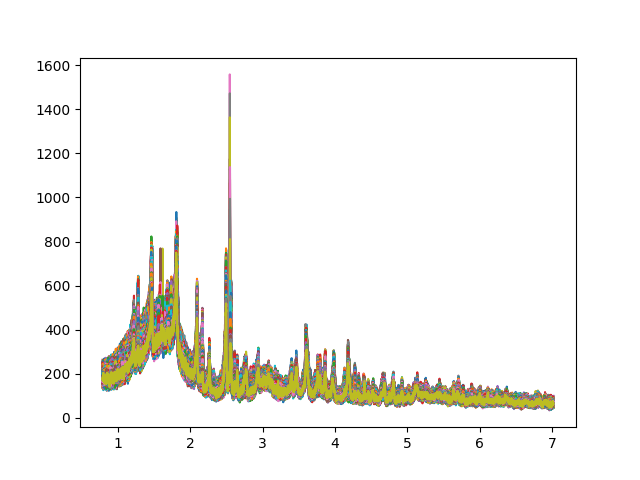

In [9]:
%matplotlib widget
plt.figure()
for k in list(d.keys()):
    plt.plot(d[k]["x"], d[k]["y"])
# plt.ion()
plt.show()

Minimum and maximum x-values for scaling.

In [11]:
xmin = float(input("Please provide the minimum x-value for scaling: "))
xmax = float(input("Please provide the maximum x-value for scaling: "))
print(f"{80*'-'}\nxmin = {xmin}\nxmax = {xmax}\n{80*'-'}")

--------------------------------------------------------------------------------
xmin = 0.8
xmax = 1.1
--------------------------------------------------------------------------------


Exploring data normalization.

In [12]:
from skbeam.core.utils import q_to_twotheta

def xye_calc(x, y):
    wl, sdd = 0.559407, 38
    tt = q_to_twotheta(x, wl)
    normalizer = np.array([2 * np.pi * sdd * np.tan(x[i]) / 0.150
                           for i in range(len(x))
                           ])
    esd = np.sqrt(y / normalizer)

    return np.column_stack((x, y, esd))


def basecase_calc(x, y, xmin, xmax):
    basecase = 0
    for i in range(len(x)):
        if xmin <= x[i] <= xmax:
            basecase += y[i]

    return basecase


def norm_factor_calc(x, y, xmin, xmax, basecase):
    intensity_sum = 0
    for i in range(len(y)):
        if xmin <= x[i] <= xmax:
            intensity_sum += y[i]
    if intensity_sum == 0:
        norm_factor = 1
    else:
        norm_factor = basecase / intensity_sum

    return norm_factor


def normalizer(xye, xmin, xmax, basecase, norm_factor):
    x, y, e = xye[:,0], xye[:,1], xye[:,2]
    norm_factor = norm_factor_calc(x, y, basecase, xmin, xmax)
    y_norm, e_norm = y * norm_factor, e * norm_factor
    xye_norm = np.column_stack((x, y_norm, e_norm))

    return xye_norm

for i, k in enumerate(list(d.keys())):
    d[k]["xye"] = xye_calc(d[k]["x"], d[k]["y"])
    if i == 0:
        basecase = basecase_calc(d[k]["x"], d[k]["y"], xmin, xmax)
    norm_factor = norm_factor_calc(d[k]["x"], d[k]["y"], xmin, xmax, basecase)
    d[k]["xye_norm"] = normalizer(d[k]["xye"], xmin, xmax, basecase, norm_factor)

C:\Users\au714043\AppData\Local\Temp\ipykernel_18928\3284094532.py:9: RuntimeWarning: invalid value encountered in sqrt
  esd = np.sqrt(y / normalizer)


Plotting normalized scans prior to background subtraction.

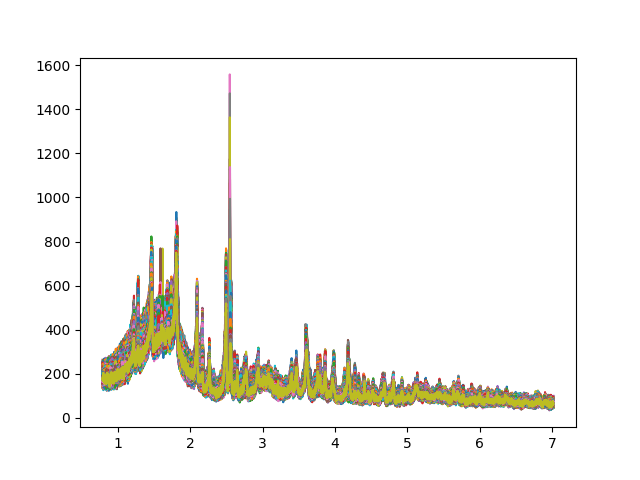

In [13]:
%matplotlib widget
plt.figure()
for k in list(d.keys()):
    plt.plot(d[k]["xye_norm"][:, 0], d[k]["xye_norm"][:, 1])
plt.show()

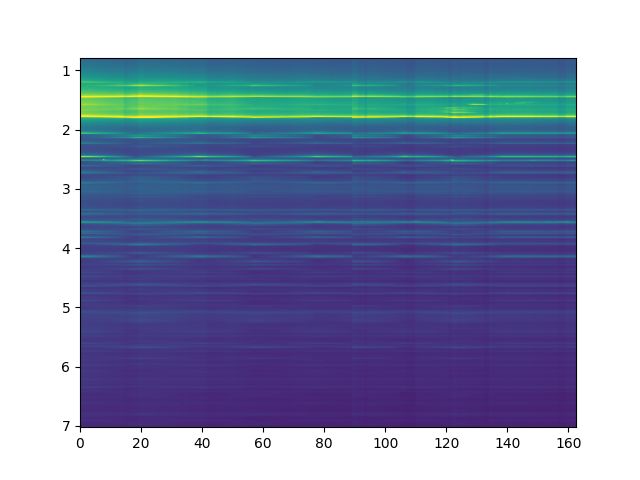

In [14]:
%matplotlib widget
d_plot = D_PLOT
duration_h = duration / 60**2
fig, ax = plt.subplots()
for i, k in enumerate(d.keys()):
    if i == 0:
        x = d[k]["xye_norm"][:, 0]
        y = d[k]["xye_norm"][:, 1]
    else:
        y = np.column_stack((y, d[k]["xye_norm"][:, 1]))
cmap = colormaps[d_plot["cmap"]].set_bad(color=d_plot["cmap_bad"])
ax.imshow(y,
          cmap=cmap,
          interpolation=d_plot["interpolation"],
          aspect=d_plot["aspect"],
          origin=d_plot["origin"],
          vmin=0,
          vmax=np.amax(y) / d_plot["vmax_scale"],
          extent=(0, duration_h, np.amax(x), np.amin(x)),
          )
plt.show()

Obtaining scale factor.

In [15]:
scales = []
scans = list(d.keys())
oom = 10**-3
for scan in scans:
    scales.append(xy_scale(d[scan]["xye_norm"][:, 1], d_bkg["y"], oom))
scale = np.amin(np.array(scales))
scale_str = f"{scale:.3f}"
print(f"{80*'-'}\nMaximum scale factor value for no negative intensities: "
      f"{scale_str}"
      )
scale_path = Path.cwd() / "scale.txt"
with scale_path.open(mode="w", encoding="utf-8") as f:
    f.write(scale_str)
print(f"Scale factor written to {scale_path.name} file.\n{80*'-'}")

--------------------------------------------------------------------------------
Maximum scale factor value for no negative intensities: 0.767
Scale factor written to scale.txt file.
--------------------------------------------------------------------------------


## NB
The scale factor obtained for the scaled data files are the same as those that
are not scaled. Also, overview plots seem similar.

Background subtraction.

In [16]:
data_bkg_sub_path = Path.cwd() / "data_bkg-sub"
if not data_bkg_sub_path.exists():
    data_bkg_sub_path.mkdir()
print(f"{80*'-'}\nWriting background-subtracted files to the "
      f"'{data_bkg_sub_path.name}' folder..."
      )
for scan in scans:
    d[scan]["y_bkg_sub"] = d[scan]["xye"][:, 1] - (scale * d_bkg["y"])
    np.savetxt(data_bkg_sub_path / data_files[scan].name,
               np.column_stack((d[scan]["x"], d[scan]["y_bkg_sub"])),
               delimiter="\t",
               fmt="%.8f\t%.1f",
               encoding="utf-8",
               )
print(f"Done.\n{80*'-'}")

--------------------------------------------------------------------------------
Writing background-subtracted files to the 'data_bkg-sub' folder...
Done.
--------------------------------------------------------------------------------


Copying all data files and dummy scans.

In [17]:
data_all_path = Path.cwd() / "data_all"
data_bkg_sub_files = list(data_bkg_sub_path.glob("*.*"))
data_dummy_files = list(data_dummy_path.glob("*.*"))
if not data_all_path.exists():
    data_all_path.mkdir()
print(f"{80*'-'}\nCopying background-subtracted files and dummy files to "
      f"the '{data_all_path.name}' folder..."
      )
for f in data_bkg_sub_files:
    (data_all_path / f.name).write_text(f.read_text())
for f in data_dummy_files:
    (data_all_path / f.name).write_text(f.read_text())
print(f"Done.\n{80*'-'}")

--------------------------------------------------------------------------------
Copying background-subtracted files and dummy files to the 'data_all' folder...
Done.
--------------------------------------------------------------------------------


Creating matrix and writing to `.npy` and `.csv` files.

In [18]:
print(f"{80*'-'}\nCreating matrix...")
data_all_files = list(data_all_path.glob("*.*"))
d = {}
for i, e in enumerate(data_all_files):
    d[i] = xy_to_dict(e)
array = dict_to_array(d)
print(f"Done.\n{80*'-'}\nWriting to .npy file...")
basename = data_all_files[0].stem.split(".")[0]
npy_path = Path.cwd() / "npy"
if not npy_path.exists():
    npy_path.mkdir()
np.save(npy_path / basename, array)
print(f"Done. Please see the '{npy_path.name}' folder.\n{80*'-'}\n"
      f"Writing to .csv file..."
      )
csv_path = Path.cwd() / "csv"
if not csv_path.exists():
    csv_path.mkdir()
cols = ["x"]
for e in range(len(data_all_files)):
    cols.append(str(e))
df = pd.DataFrame(array, columns=cols)
df.to_csv(csv_path / f"{basename}.csv")
print(f"Done. Please see the '{csv_path.name}' folder.\n{80*'-'}")

--------------------------------------------------------------------------------
Creating matrix...
Done.
--------------------------------------------------------------------------------
Writing to .npy file...
Done. Please see the 'npy' folder.
--------------------------------------------------------------------------------
Writing to .csv file...
Done. Please see the 'csv' folder.
--------------------------------------------------------------------------------


x-ranges to plot.

In [19]:
x = np.loadtxt(data_files[0])[:, 0]
xmin, xmax = np.amin(x), np.amax(x)
print(f"{80*'-'}\nMinimum x-value in data: {xmin}"
      f"\nMaximum x-value in data: {xmax}\n{80*'-'}"
      )
xmin = float(input(f"Please provide the minimum x-value to plot: "))
xmax = float(input(f"Please provide the maximum x-value to plot: "))
xmin_index, xmax_index = 0, -1
for i in range(len(x)):
    if xmin <= x[i]:
        xmin_index = i
        break
for i in range(len(x)):
    if xmax <= x[i]:
        xmax_index = i
        break

--------------------------------------------------------------------------------
Minimum x-value in data: 0.78397238
Maximum x-value in data: 7.02178907
--------------------------------------------------------------------------------


In [20]:
print(f"{80*'-'}\nPlotting...")
png_path, pdf_path = Path.cwd() / "png", Path.cwd() / "pdf"
svg_path = Path.cwd() / "svg"
plot_paths = [png_path, pdf_path, svg_path]
plot_folders = [p.name for p in plot_paths]
for p in plot_paths:
    if not p.exists():
        p.mkdir()
plot(array[xmin_index:xmax_index+1, :], 
     duration / 60**2, 
     D_PLOT, 
     basename, 
     plot_paths,
     )
print(f"Done. Please see the {plot_folders} folders.\n{80*'-'}")

--------------------------------------------------------------------------------
Plotting...
	png
	pdf
	svg
Done. Please see the ['png', 'pdf', 'svg'] folders.
--------------------------------------------------------------------------------
